In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv
/kaggle/input/rossmann-store-sales/store.csv


# Importing Libraries

In [2]:
import pandas as pd					# data manipulation using dataframes
import numpy as np					# data statistical analysis

import seaborn as sns				# Statistical data visualization
import matplotlib.pyplot as plt		# data visualisation
%matplotlib inline

In [3]:
# To display all rows and columns

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
from datetime import datetime

In [5]:
from fbprophet import Prophet

# Importing dataset

In [6]:
raw_store_df = pd.read_csv("../input/rossmann-store-sales/store.csv")			# to import .csv file
raw_train_df = pd.read_csv("../input/rossmann-store-sales/train.csv")
raw_test_df = pd.read_csv("../input/rossmann-store-sales/test.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Inspection

### Store Data

In [7]:
store_df = raw_store_df.copy()			# copy of initial dataset

In [8]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
store_df.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [10]:
store_df.shape

(1115, 10)

In [11]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
store_df["Store"].value_counts().sum()

1115

* Total stores = 1115
* Lot of missing values in columns like Promo2SinceWeek, Promo2SinceYear, PromoInterval etc.

In [13]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


* Averge distance for competitive store = 5.4km; min = 20m; max = 75.8 km


### Sales Data

In [14]:
train_df = raw_train_df.copy()			# copy of initial dataset

In [15]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [16]:
train_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [17]:
train_df.shape

(1017209, 9)

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


* 9 columns
* 8 features
* 1 target which is sales
* No null values

In [19]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


* Average Sales per Day = 5773; min = 0; max = 41551
* Average Customer Visit = 633; min = 0; max = 7388

# Exploratory Data Analysis

## Store Data

In [20]:
store_df1 = store_df.copy()

### Checking NULL values

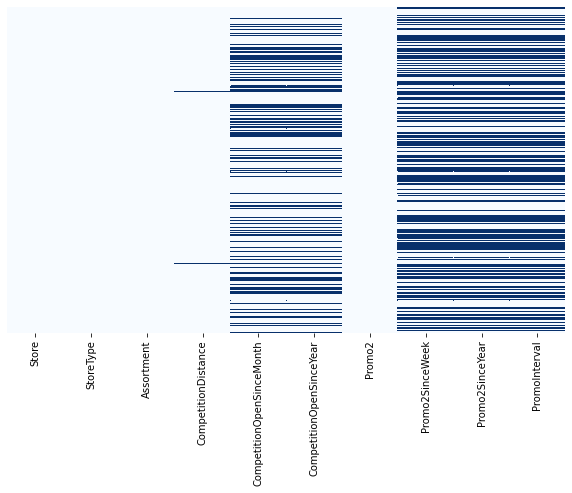

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(store_df1.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')
plt.show()

* There are lot of missing values in store dataset. Let's check them

In [22]:
store_df1.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

* 'CompetitionDistance' has 3 missing values.

In [23]:
store_df1[store_df1["CompetitionDistance"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


* Filling with mean value

In [24]:
store_df1['CompetitionDistance'].fillna(store_df1['CompetitionDistance'].mean(), inplace=True)

In [25]:
store_df1[store_df1["CompetitionOpenSinceMonth"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.000000,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.000000,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.000000,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.000000,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.000000,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.000000,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.000000,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.000000,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.000000,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.000000,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [26]:
store_df1[store_df1["Promo2SinceWeek"].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000000,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.000000,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.000000,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.000000,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.000000,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.000000,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.000000,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.000000,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.000000,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.000000,8.0,2005.0,0,NaN,NaN,NaN


* All 'Promo2' have 0 value for missing data for columns 'Promo2SinceWeek', 'Promo2SinceYear', PromoInterval

In [27]:
store_df1['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

* 'Promo2' shows that store participating in promos. If '1', then it participating else not.
* Stores which are not participating in promos have NULL values for columns Promo2SinceWeek, Promo2SinceYear and PromoInterval

Let's fill these missing values for columns CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear and PromoInterval with 0

In [28]:
store_df1.fillna(0, inplace=True)

In [29]:
store_df1.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Hence, there is no missing data in Store dataset

### Check Duplicate Values

In [30]:
store_df1['Store'].duplicated().sum()

0

* There is no duplicate value

### Check Outliers

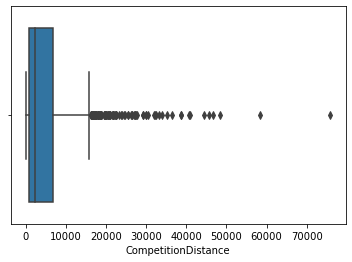

In [31]:
sns.boxplot(store_df1['CompetitionDistance'])

* Well there is few outliers for 'competitive distance' which is too far and hence, dont give much competition to store. 
* Also facebook prophet is not affected by outliers

### Data Visualization

In [32]:
store_df2 = store_df1.copy()

In [33]:
store_df2.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


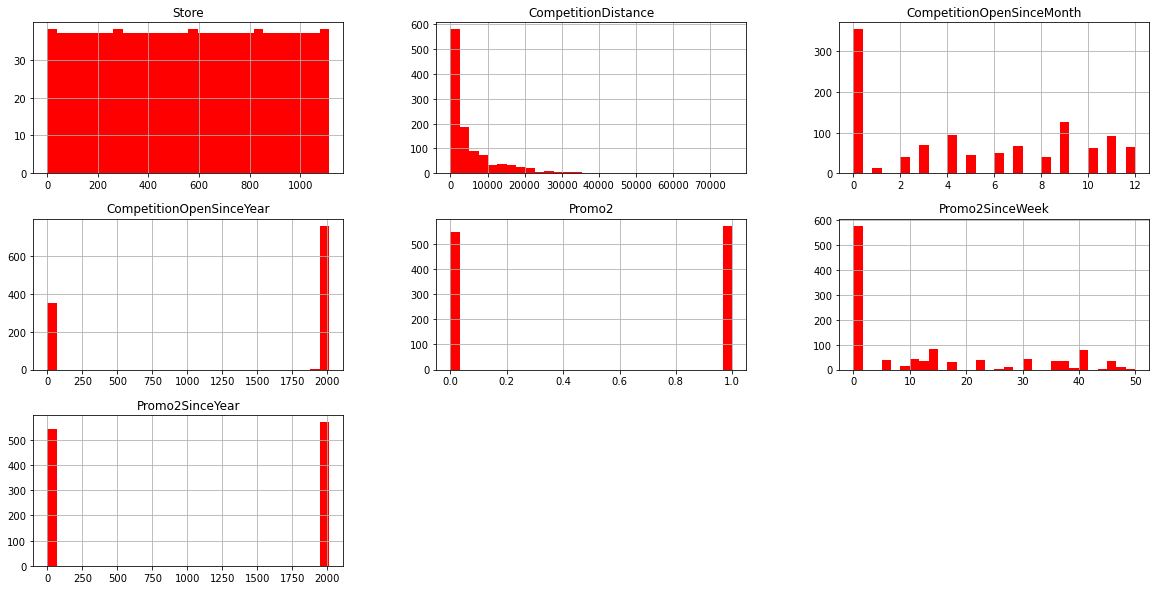

In [34]:
# to check all variables at once

store_df2.hist( bins = 30, figsize = (20,10), color = 'r')
plt.show()

* Store: for uniquly identifies all store
* Competition Distance: Most of the competitive store are under 5 km
* Promo2: Nearly half of the stores have promos going on which is not good. For increasing sales, there is great need to boost this up.


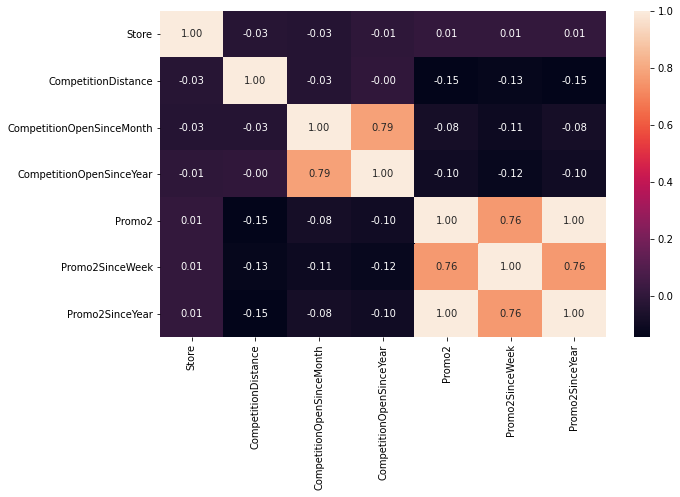

In [35]:
# Calculate correlations
corr = store_df2.corr()
 
# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr,  annot=True, fmt=".2f")
plt.show()

* There is no such correlations in store dataset

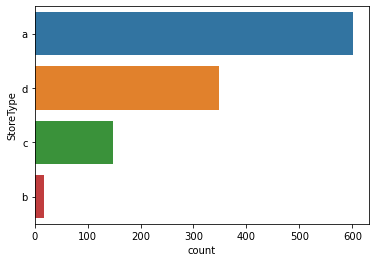

In [36]:
sns.countplot(y="StoreType", data=store_df2, order = store_df2['StoreType'].value_counts().index)

* Most of the store related to 'a' model then 'd', 'c' and 'b'

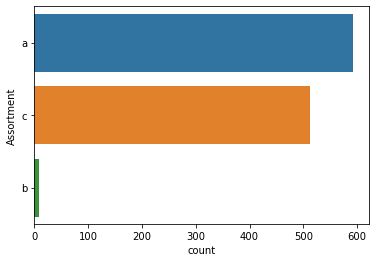

In [37]:
sns.countplot(y="Assortment", data=store_df2, order = store_df2['Assortment'].value_counts().index)

* Most of the stores are either 'basic' or 'extended' stores
* Very few stores are of 'extra' category having collection more than 'basic'

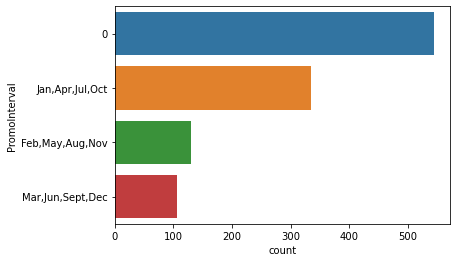

In [38]:
sns.countplot(y="PromoInterval", data=store_df2, order = store_df2['PromoInterval'].value_counts().index)

* Most of the promos held in month 'January', 'April', 'July' and 'October'

> ## Sales data

In [39]:
train_df1 = train_df.copy()

### Cheking NULL Values

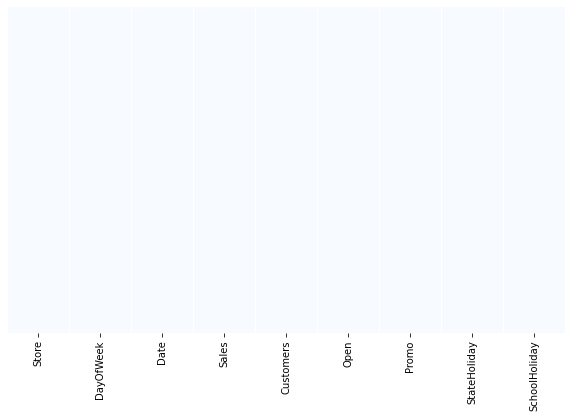

In [40]:
plt.figure(figsize=(10,6))
sns.heatmap(train_df1.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')
plt.show()

* Bam! There is no missing values. Let us confirm.

In [41]:
train_df1.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

* Thus, there is no missing values

### Duplicate Entries

In [42]:
train_df1['Store'].duplicated().sum()

1016094

* Thus Stores have lot duplicate entries
* Its obvious as this dataset have Sales on different days for each stores.

### Outlier Analysis

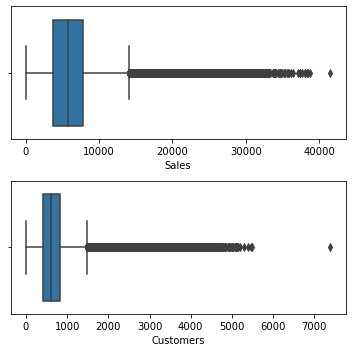

In [43]:
fig, axs = plt.subplots(2, figsize = (5,5))
plt1 = sns.boxplot(train_df1['Sales'], ax = axs[0])
plt2 = sns.boxplot(train_df1['Customers'], ax = axs[1])
plt.tight_layout()

* Outliers present in both columns for 'Sales' and 'Customers'
* Well Facebook Prophet is not impact by outliers. So we ignore them

### Data Visualization

In [44]:
train_df2 = train_df1.copy()

In [45]:
train_df2.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


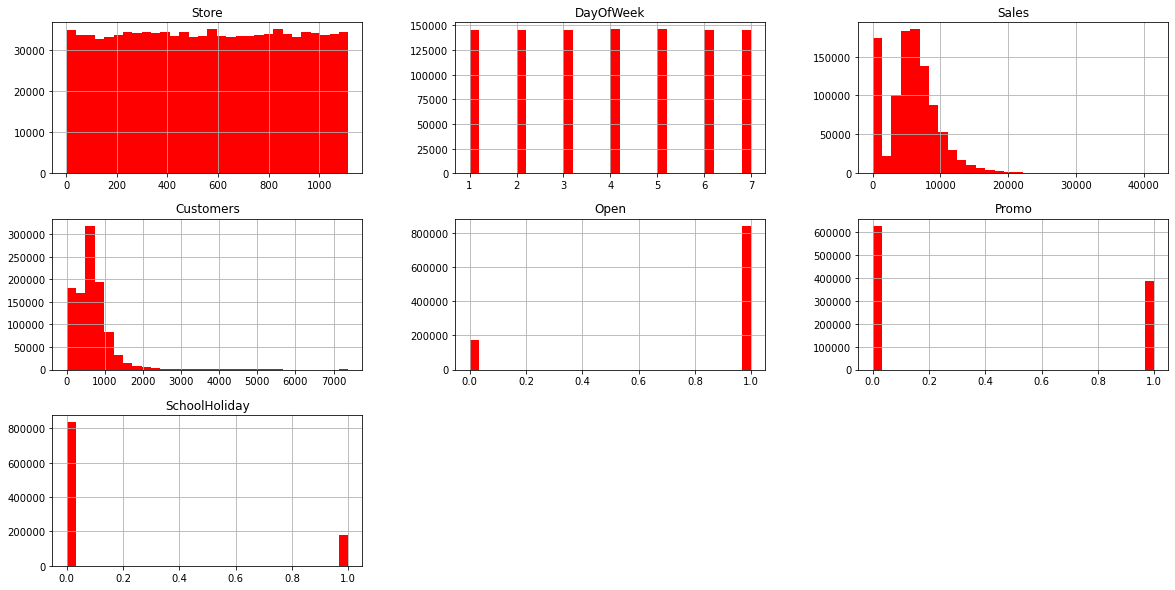

In [46]:
# to check all variables at once

train_df2.hist( bins = 30, figsize = (20,10), color = 'r')
plt.show()

* Store: All stores have approx good information
* Day of week: All days have information which is good
* Sales: 


In [47]:
close_df = train_df2[train_df2['Open'] == 0]
open_df = train_df2[train_df2['Open'] == 1]

In [48]:
close_df.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1
3105,876,3,2015-07-29,0,0,0,1,0,1
3636,292,2,2015-07-28,0,0,0,1,0,1
4220,876,2,2015-07-28,0,0,0,1,0,1
4751,292,1,2015-07-27,0,0,0,1,0,1
5335,876,1,2015-07-27,0,0,0,1,0,1


* There is no data if store is close. So we remove dadat from this for close store and drop "open" column

In [49]:
open_df = open_df.drop(['Open'], axis = 1)

In [50]:
open_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [51]:
open_df.shape

(844392, 8)

## Merge Data for each Store and its Sales

In [52]:
df = pd.merge(open_df, store_df2, on = 'Store', how = 'inner')

In [53]:
df.shape

(844392, 17)

In [54]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [55]:
df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844391,292,3,2013-01-02,5076,672,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


In [56]:
df['Date'] = pd.to_datetime(df['Date'],
                              format='%Y-%m-%d')

* Change datatype for date time to date category

In [57]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [58]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day'],
      dtype='object')

In [59]:
df = df[['Store', 'Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'Customers', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Sales']]

In [60]:
df.head()

,Store,Date,Year,Month,Day,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales
0,1,2015-07-31,2015,7,31,5,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5263
1,1,2015-07-30,2015,7,30,4,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5020
2,1,2015-07-29,2015,7,29,3,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,4782
3,1,2015-07-28,2015,7,28,2,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5011
4,1,2015-07-27,2015,7,27,1,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,6102


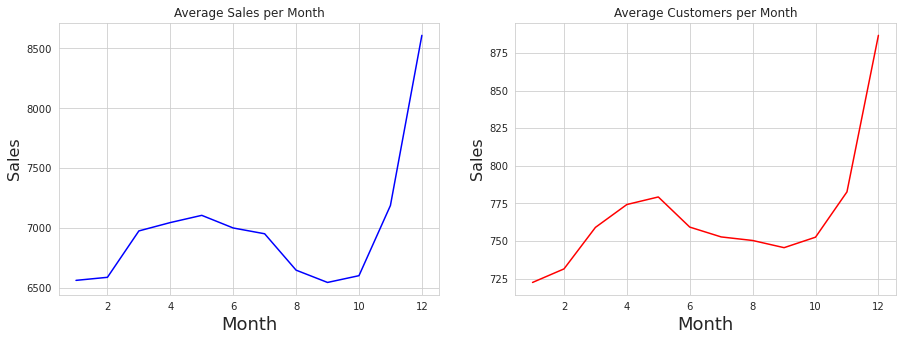

In [61]:
plt.figure(figsize=(15,5))
sns.set_style('whitegrid')

plt.subplot(1, 2, 1)
plt.plot(df.groupby('Month')['Sales'].describe()['mean'], color = 'b')
plt.title('Average Sales per Month')
plt.xlabel('Month', fontsize=18)
plt.ylabel('Sales', fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(df.groupby('Month')['Customers'].describe()['mean'], color = 'r')
plt.title('Average Customers per Month')
plt.xlabel('Month', fontsize=18)
plt.ylabel('Sales', fontsize=16)

plt.show()

* "Sales" and "Customers" are at peak in December which is Christmas month.
* "Sales" and "Customers" are little high from month between April to June due to 
** Festive season for easter and good friday
** Academic leaves

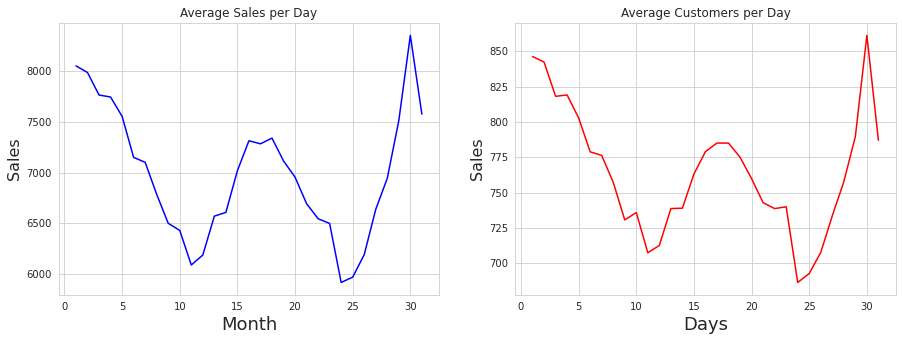

In [62]:
plt.figure(figsize=(15,5))
sns.set_style('whitegrid')

plt.subplot(1, 2, 1)
plt.plot(df.groupby('Day')['Sales'].describe()['mean'], color = 'b')
plt.title('Average Sales per Day')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Sales', fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(df.groupby('Day')['Customers'].describe()['mean'], color = 'r')
plt.title('Average Customers per Day')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Sales', fontsize=16)

plt.show()

* "Sales" and "Customers" are at peak in on 1st and 31st of each month when generally salary arrives for employess in private and government owned companies

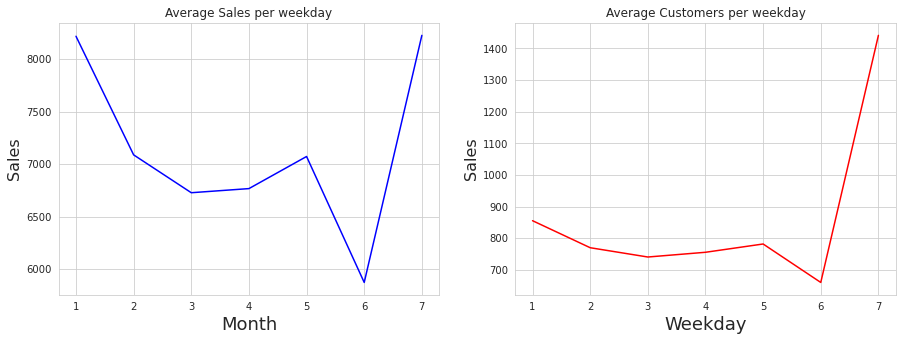

In [63]:
plt.figure(figsize=(15,5))
sns.set_style('whitegrid')

plt.subplot(1, 2, 1)
plt.plot(df.groupby('DayOfWeek')['Sales'].describe()['mean'], color = 'b')
plt.title('Average Sales per weekday')
plt.xlabel('Weekday', fontsize=18)
plt.ylabel('Sales', fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(df.groupby('DayOfWeek')['Customers'].describe()['mean'], color = 'r')
plt.title('Average Customers per weekday')
plt.xlabel('Weekday', fontsize=18)
plt.ylabel('Sales', fontsize=16)

plt.show()

* "Sales" and "Customers" are at peak on Sunday and Monday due to weekends
* Litle high on Friday
* And least on Saturday on which people choose to stay and rest at home

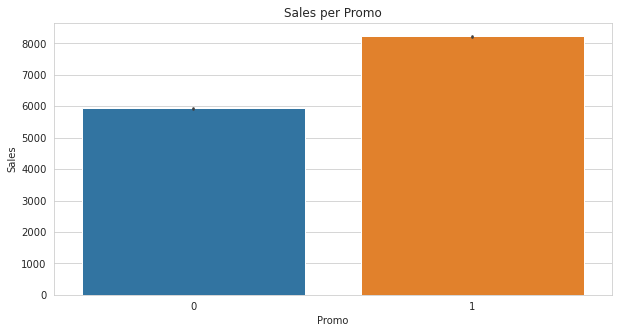

In [64]:
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')

sns.barplot(x='Promo',y='Sales',data=df)

plt.title('Sales per Promo')

plt.show()

* 'Promo' affects Sales. If we go for promo, then it boosts Sales

In [ ]:
plt.figure(figsize=(15,5))
sns.set_style('whitegrid')

sns.violinplot(x="StoreType", y="Sales", data=df, palette='rainbow')

plt.title('Sales for store type')

plt.show()

* Maximum Sale amount given by store type a & b, but their median sales of each store is about 5000 euros

# Model Training & Prediction

In [ ]:
df.head()

### Facebook prophet model for each store to forecast its sales

In [ ]:
def store(df, store_ID, period):
    store_df = df[df['Store']==store_ID]
    store_df = store_df[['Date', 'Sales']]
    store_df = store_df.sort_values(by=['Date'])
    store_df.columns = ['ds', 'y']
    
    model = Prophet()
    model.fit(store_df)
    
    future = model.make_future_dataframe(periods=period)
    
    forecast = model.predict(future)
    
    fig1 = model.plot(forecast)
    
    fig2 = model.plot_components(forecast)

Let's predict and plot sales forecast for 'Store 10' upto 120 days 

In [ ]:
store_forecast_df = store(df, 10, 120)

**Store 10**

* Trend of Sales is increasing with time 
* Most of the sales is on Monday
* During December, sales at its peak. It's obvious due to christmas

Let's predict and plot sales forecast for 'Store 6' upto 90 days 

In [ ]:
store_forecast_df = store(df, 6, 90)

**Store 6**

* Trend of Sales is decreasing with time 
* Most of the sales is on Monday and Friday
* During December, sales at its peak. It's obvious due to christmas

### Facebook prophet model for each store to forecast its sales with holiday impact

In [ ]:
def holidays(df):
    
    school_holiday = pd.DataFrame({
        'holiday': 'School Holiday',
        'ds':  df['Date'][df['SchoolHoliday'] == 1]
    })

    state_holiday = pd.DataFrame({
        'holiday': 'State Holiday',
        'ds':  df['Date'][(df['StateHoliday'] == 'a') | (df['StateHoliday'] == 'b') | (df['StateHoliday'] == 'c')]
    })

    holiday = pd.concat([school_holiday, state_holiday])
    holiday = holiday.sort_values(by=['ds'])

    return holiday

def store_with_holidays(df, store_ID, period):
    
    store_df = df[df['Store']==store_ID]
    store_df = store_df[['Date', 'Sales']]
    store_df = store_df.sort_values(by=['Date'])
    store_df.columns = ['ds', 'y']
    

    
    model = Prophet(holidays = holidays(df))
    model.fit(store_df)
    
    future = model.make_future_dataframe(periods=period)
    
    forecast = model.predict(future)
    
    fig1 = model.plot(forecast)
    
    fig2 = model.plot_components(forecast)

Let's predict and plot sales forecast for 'Store 6' upto 90 days 

In [ ]:
store_forecast_df = store_with_holidays(df, 6, 90)

# Conclusion

This was an interesting study and it’ll be great to analyse the results when I get the actual views. Having said that, Prophet does make the entire forecasting process easy and intuitive and also gives a lot of options. The actual advantage of this model can only be assessed on large datasets but Prophet does enable forecasting a large number and a variety of time series problems — which is truly forecasting at scale.